In [2]:
from pathlib import Path
import sys
sys.path.append(Path.cwd() / "SolverFiles")

In [4]:
from matplotlib import pyplot as plt
import itertools
import numpy as np
import pandas as pd
import re
from collections import defaultdict
from evrp_instance_parser import parse_instance_file

In [5]:
%matplotlib inline

In [7]:
target = "c101C5"
instance_path = (Path.cwd().parent / "Cplex5er" / target).with_suffix(".txt")
instance = parse_instance_file(instance_path)
solutions = {csv.name: pd.read_csv(csv) for csv in (Path.cwd() / "Solution" / "base" / "small_instances" / "Cplex5er" / target).glob("*.csv")}

In [8]:
def extract_node_locations(solution):
    columns = [col.split("|")[0] for col in solution.columns if "Unnamed" not in col]
    return columns

In [9]:
vehicle_color = itertools.cycle(["blue", "green", "red"])

/var/folders/tw/0v6766md5pn_56mm6ylj9h8h0000gn/T/ipykernel_1727/512348070.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


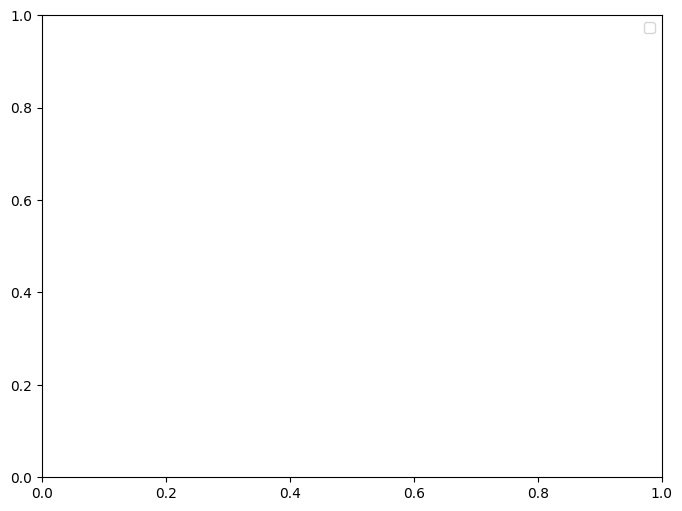

In [11]:
plt.figure(figsize=(8, 6))
for vehicle, solution in solutions.items():
    nodes = instance.data.loc[instance.data["StringID"].isin(extract_node_locations(solution)), :]
    x = nodes.x.astype(float).tolist()
    y = nodes.y.astype(float).tolist()
    
    # Calculate the direction vectors
    dx = np.diff(x)  # Difference in x-coordinates
    dy = np.diff(y)  # Difference in y-coordinates
    
    # Plot the line chart with arrows
    
    plt.quiver(
        x[:-1], y[:-1], dx, dy, 
        angles='xy', scale_units='xy', scale=1, color = next(vehicle_color), width=0.005, label=vehicle
    )
    line = plt.scatter(x, y, color='black')  # Plot points for reference
    # plt.title("Line Chart with Directed Arrows")
    # plt.xlabel("X-axis")
    # plt.ylabel("Y-axis")
    # plt.grid(True)
    
    # plt.show()

    for (id, x_coord, y_coord) in zip(nodes.StringID, x, y):
        plt.annotate(
            id,  # Text for annotation
            (x_coord, y_coord),        # Data point location
            textcoords="offset points",  # Position relative to the point
            xytext=(-10, -10),              # Offset (x, y) in points
            ha='center',                # Horizontal alignment
            fontsize=9,                 # Font size
            color='black'               # Text color
        )

# line.set_label("Data Points")
plt.legend()
plt.show()

In [45]:
objective_extraction_regex = re.compile(r"objective:\s*(\d+)")
objectives = defaultdict(lambda: defaultdict(lambda: list))
vehicles = defaultdict(lambda: defaultdict(lambda: list))
time_taken = defaultdict(lambda: defaultdict(lambda: list))
total_time = defaultdict(lambda: defaultdict(lambda: list))
start_end_times = defaultdict(lambda: defaultdict(lambda: list))

for file_path in (Path.cwd().parent / "Solution").glob("**/*.txt"):
    with open(file_path) as f:
        file = f.read()
    objective_value = float(objective_extraction_regex.search(file).group(1))
    case_name = file_path.parent.parent.parent.parent.name
    instance_name = file_path.parent.name
    if case_name.startswith("case") or case_name == "base":
        if case_name == "case_1":
            objective_value /= 1e6
        objectives[case_name][instance_name] = objective_value
        vehicles[case_name][instance_name] = len([x for x in file_path.parent.glob("*.csv")])
        start_end_times[case_name][instance_name] = max([(pd.read_csv(x).iloc[2,-1].item(), pd.read_csv(x).iloc[2,1].item()) for x in file_path.parent.glob("*.csv")], key=lambda x: x[0] - x[1])
        time_taken[case_name][instance_name] = max([pd.read_csv(x).iloc[2,-1].item() - pd.read_csv(x).iloc[2,1].item() for x in file_path.parent.glob("*.csv")])
        total_time[case_name][instance_name] = max([pd.read_csv(x).iloc[2,-1].item() for x in file_path.parent.glob("*.csv")])

In [49]:
pd.DataFrame(total_time).sort_index().loc[: , ["base", "case_1", "case_2", "case_3"]].to_csv("../Solution/total_time.csv")

In [50]:
df = pd.DataFrame(start_end_times).sort_index().loc[: , ["base", "case_1", "case_2", "case_3"]]

In [51]:
df

,base,case_1,case_2,case_3
c101C5,"(895.6017383708108, 143.12199135548792)","(1105.4533423567711, 34.55746735045424)","(856.7321374946365, 137.92113447068044)","(856.7321374946371, 22.815198827294346)"
c103C5,"(1224.137011749777, 126.1937515251343)","(1195.75347189897, 0.0)","(1129.2815677003405, 54.1937515251343)","(1188.0, 112.91218382479371)"
c206C5,"(2082.0788655293195, 1053.752130881638)","(2091.3882694814033, 325.2667257213356)","(2230.4698170013894, 1056.9651489620169)","(1893.6247371550528, 932.188611699158)"
c208C5,"(1857.0149750907892, 872.1964914980173)","(2410.9602539186017, 668.5483694100564)","(1885.7522908856663, 872.1964914980173)","(1960.877578645956, 872.1964914980173)"
r104C5,"(134.59333942014666, 20.768453788272183)","(194.38477631085024, 42.55767965579487)","(142.93464101079556, 20.768453788272183)","(150.92558226241712, 20.768453788272183)"
r105C5,"(209.32455532033677, 46.57863193164641)","(223.77559263493532, 51.2151120211004)","(209.32455532033677, 50.60003324666502)","(209.32455532033677, 49.317716290207386)"
r202C5,"(428.8113883008419, 179.69717988314895)","(356.8598261325584, 66.3022843964078)","(428.8113883008419, 182.6486943091029)","(428.8113883008419, 223.34048922831025)"
r203C5,"(785.2572976832834, 479.1252879293721)","(796.9661991411779, 404.5982323096734)","(682.4144987024775, 384.45898033750314)","(625.9705627484772, 284.4996248128713)"
rc105C5,"(168.02749956186543, 0.0)","(196.9526811106383, 4.134177474627563)","(168.02749956186543, 0.0)","(195.53121660865068, 2.7127129726581387)"
rc108C5,"(230.42313739457393, 10.0)","(240.0, 9.999999999999917)","(234.57137430032355, 18.88618587669189)","(224.66876695915423, 10.0)"


array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

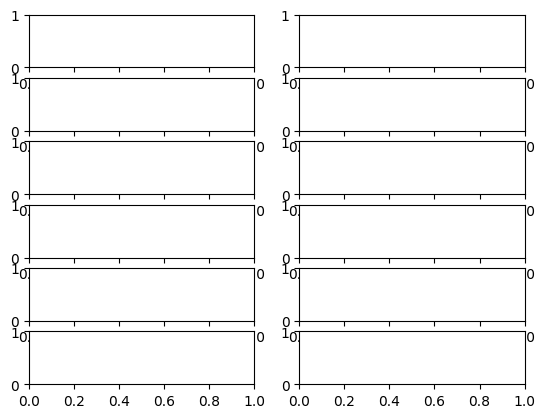

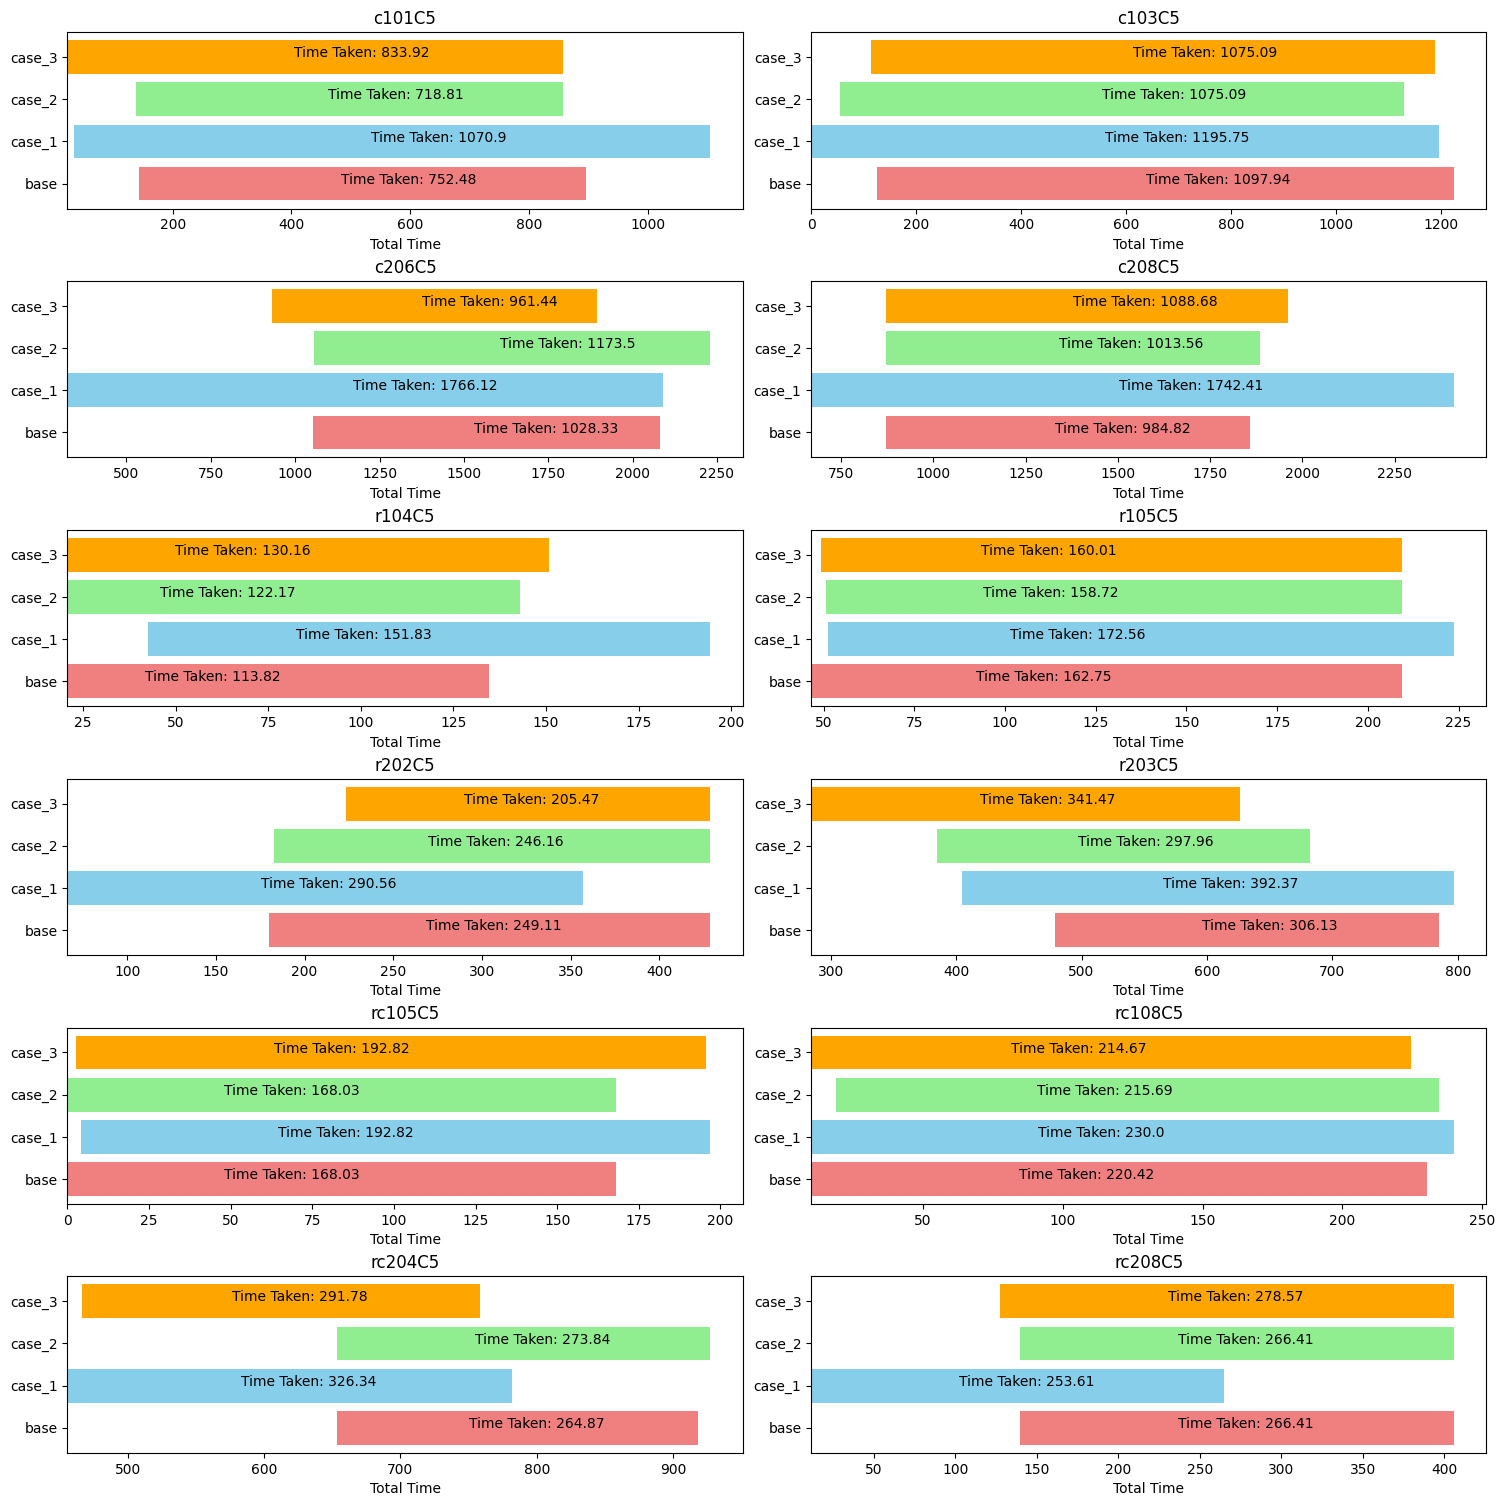

In [148]:
fig, ax = plt.subplots(6,2, figsize=(15, 15))
colors = ["lightcoral", "skyblue", "lightgreen", "orange"]
for i, (instance, data) in enumerate(df.iterrows()):
    duration = [x[0] - x[1] for x in data]
    start = [x[1] for x in data]
    ax[(i // 2, i % 2)].barh(data.index, duration, left=start, color=colors)
    for bar in ax[(i // 2, i % 2)].patches:
        text = f"Time Taken: {bar.get_width().round(2)}"
        ax[(i // 2, i % 2)].text(bar.get_x() - 2 * len(text) + bar.get_width() / 2 , bar.get_y() + bar.get_height() / 2, text)
    ax[(i // 2, i % 2)].title.set_text(instance)
    ax[(i // 2, i % 2)].set(xlabel="Total Time")

fig.tight_layout(pad=0.5)
fig.savefig("foo.svg")

In [111]:
bar.get_y()+bar.get_height()/2

np.float64(3.0)